# Poleward Heat Transport

`mom6_tools.polar_heat_transport` collection of functions for computing and plotting poleward heat transport.

The goal of this notebook is the following:

1) server as an example on to compute polar heat transport from CESM/MOM output; 

2) evaluate model experiments by comparing transports against observed estimates;

3) compare model results vs. another model results (TODO).

In [1]:
%matplotlib inline
from mom6_tools.poleward_heat_transport import  *
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.ClimoGenerator import ClimoGenerator
import yaml
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [3]:
# Create the case instance
dcase = DiagsCase(diag_config_yml['hm'])
print('Casename is:', dcase.casename)

Casename is: bmom.e20.BMOM.f09_t061.long_run_mct.003


In [4]:
# Load the grid
grd = dcase.grid
depth = grd.depth_ocean
# remove Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, verbose=False)

MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


In [5]:
# Create the climatology instance
climo = ClimoGenerator(diag_config_yml['Climo2'], dcase)

In [6]:
# Compute the climatology dataset
dset_climo = climo.stage()

In [7]:
# load model output, averaged over 20 years
ds = dset_climo['20Y']

In [8]:
# create an empty class object
class args:
  pass

args.case_name = dcase.casename
args.year_start = str(ds.time[0].values)
args.year_end = str(ds.time[1].values)
args.savefigs = False
args.label = ''

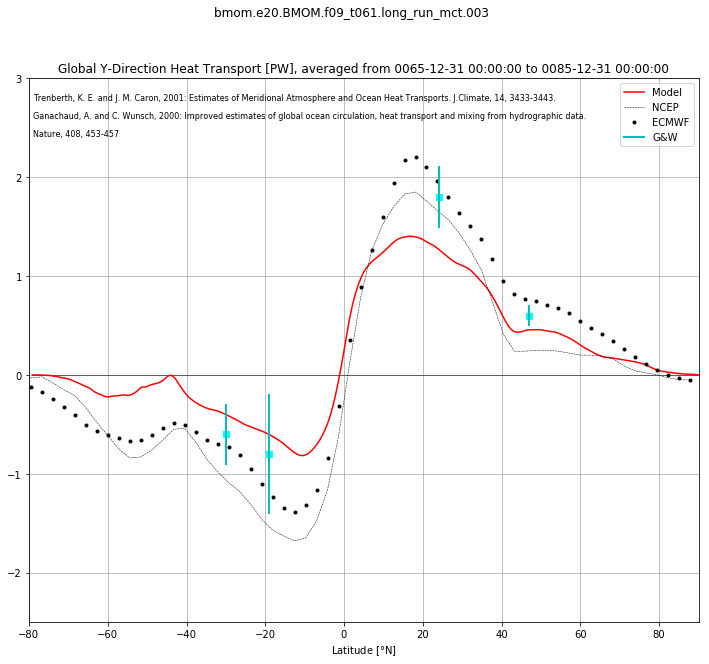

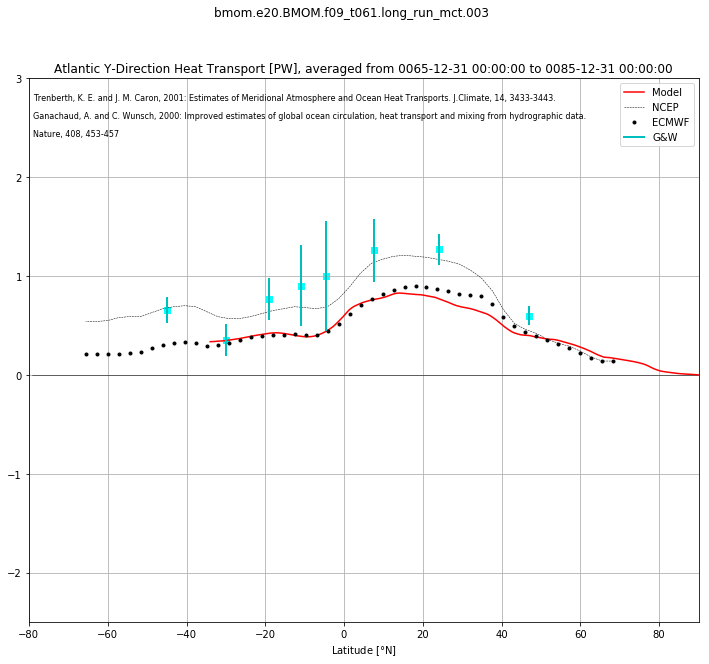

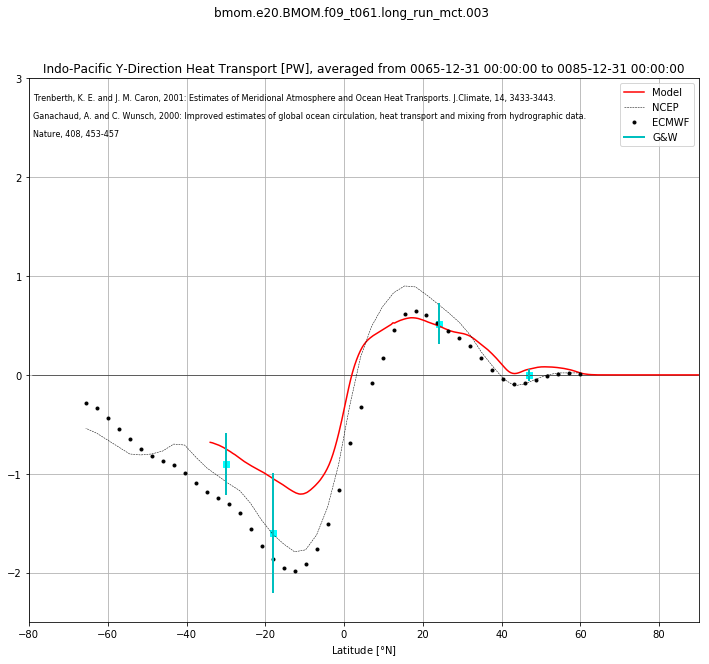

In [9]:
stream = True
# create a ndarray subclass
class C(np.ndarray): pass

varName = 'T_ady_2d'
if varName in ds.variables:
  tmp = np.ma.masked_invalid(ds[varName][-1,:].values)
  tmp = tmp[:].filled(0.)
  advective = tmp.view(C)
  advective.units = ds[varName].units
else:
  raise Exception('Could not find "T_ady_2d" in ds')

varName = 'T_diffy_2d'
if varName in ds.variables:
  tmp = np.ma.masked_invalid(ds[varName][-1,:].values)
  tmp = tmp[:].filled(0.)
  diffusive = tmp.view(C)
  diffusive.units = ds[varName].units
else:
  diffusive = None
  warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

# plot model vs obs
plt_heat_transport_model_vs_obs(advective, diffusive, basin_code, grd, args)  